# Dependence Analysis
<!-- The key to preserving the program semantics, when the program is being transformed,
lies in ensuring that the same values are written to and read from the memory, and in the same order. -->
当程序被转换时,保留程序语义的关键在于确保相同的值以相同的顺序写入和读取内存。

<!-- Conventionally, this is expressed using *data dependences*, which impose a partial execution order on the program. -->
<!-- The power of the polyhedral model lies in its ability to compute exact data dependences at the statement instance level. -->
传统上,这是使用*data dependences*来表示的, 它对程序施加了部分执行顺序约束.
多面体模型的强大之处在于它能够在statement instance级别计算精确的data dependences.

<!-- Two statement instances are said to be *dependent* if one is executed before another, they access the same array element, and at least one access writes to that element. -->
如果一个statement instances在另一个statement instances之前执行，则两个语句实例被称为*依赖*，它们访问相同的数组元素，并且至少一个访问权限写入该元素。

<!-- In the "Schedules" example, we learned how to define the order in which statement instances are executed.
In the "Memory Access" example, we defined a relation of *potentially dependent* statement instances
that access the same array element and at least one access is a write. -->
在`Schedules`章节中, 我们学习了如何定义statement instance的执行顺序.
在`Memory Access`章节中, 我们定义了*potentially dependent*的statement instance的关系, 即访问了相同的数组元素并且至少一个访问是写入。

<!-- The simplest version of dependence analysis is a combination of these two parts, so let us pick up where we stopped. -->
<!-- We are give the polynomial multiplication kernel -->
最简单的依赖分析就是将两部分结合起来, 首先我们给出一个多项式乘积的kernel:
```c
double A[10], B[10], Z[20];

for (int i = 0; i <= 20; ++i)
S:  Z[i] = 0.;
for (int i = 0; i <= 10; ++i)
    for (int j = 0; j <= 10; ++j)
T:      Z[i + j] += A[i] * B[j];
```
<!-- and know how to define domains, schedules and access relations. -->
然后定义对应的domain/schedule/access relations:


In [13]:
import islpy as isl
domain = isl.UnionSet("{S[i]: 0 <= i <= 20; T[i,j]: 0 <= i,j <= 10}")
# t0是最外层的辅助维度, 用于标记外部的执行顺序. t1/t2则是内部循环的执行顺序.
schedule = isl.UnionMap(
    "{S[i]->[t0,t1,t2]: t0 = 0 and t1 = i and t2 = 0; T[i,j]->[t0,t1,t2]: t0=1 and t1=i and t2=j}")
A_S_Z = isl.Map("{S[i]->Z[a]: a = i and 0 <= a,i <= 20}")  # S 写入Z[i]
A_T_Z = isl.Map("{T[i,j]->Z[a]: a = i + j and 0 <= i,j <= 10 and 0 <= a <= 20}")  # T写入Z[i+j]
A_T_A = isl.Map("{T[i,j]->A[a]: a = i and 0 <= a <= 20 and 0 <= i,j <= 10}")  # T读取A[i]
A_T_B = isl.Map("{T[i,j]->B[a]: a = j and 0 <= a <= 20 and 0 <= i,j <= 10}")  # T读取B[i]
writes = isl.UnionMap(A_S_Z).union(A_T_Z) 
reads = isl.UnionMap(A_T_Z).union(A_T_A).union(A_T_B)

<!-- We can also compute the set of statement instance pairs (a relation is essentially a set of pairs) that
access the same array element. -->
我们还可以计算访问相同数组元素的statement instance pair集合.

## Plugging in Schedule Information
<!-- Because statement instances are executed following the lexicographic order of their respective dates,
we need a way to express it in the relations. -->
因为statement instances是按照它们各自词典序执行的，因此我们需要一种在relation中表达它的方法。

<!-- In the simplest case, we enforce the schedules for all statements to live in the same *space*. -->
<!-- For example, we added an auxiliary dimension $(t\_2)$ to the schedule for `S` simply to have as many dimensions for `S` as for `T`. -->
<!-- *isl* then allows us to a define a map of "lexicographic less-than". -->
最简单的例子就是强制所有的statements的schedule都在相同的*space*中, 比如我们添加一个辅助维度$(t\_2)$到schedule `S`的statement `T`中

*isl* 允许我们定义`lexicographic less-than`的映射:


In [14]:
schedule_space = isl.Set("{[t0,t1,t2]:}").get_space()
precedes = isl.Map.lex_lt(schedule_space)
print(precedes)

{ [t0, t1, t2] -> [t0', t1', t2'] : t0' > t0; [t0, t1, t2] -> [t0' = t0, t1', t2'] : t1' > t1; [t0, t1, t2] -> [t0' = t0, t1' = t1, t2'] : t2' > t2 }


<!-- This map basically follows the definition of the lexicographic order.
Compare first pair of elements.
If one precedes another, the order is established.  Otherwise assume they are equal and compare the second pair.
Proceed until the final pair.
The `precedes` relation contains pairs of tuples where the first one lexicographically precedes the second one. -->

上面的map按照词典序的定义执行, 先比较第一对元素,如果一个在另一个之前, 则顺序成立. 否则假设它们相等并比较第二对, 继续直到最后一对.

`precedes` relation 即前一个词典上在后一个之前成对元组的集合.

### Question
<!-- Apply the `schedule` to the `domain` so as to map it to the schedule space.
Save the result as `scheduled_domain`. -->

将 `schedule` 应用到 `domain` 以便将其映射到调度空间,
将结果保存为 `scheduled_domain`.

In [15]:
scheduled_domain = domain.apply(schedule)
print(scheduled_domain)

{ [t0 = 1, t1, t2] : 0 <= t1 <= 10 and 0 <= t2 <= 10; [t0 = 0, t1, t2 = 0] : 0 <= t1 <= 20 }


<!-- ###  -->
<!-- Now we know how to move the relation from domain space to the schedule space: apply the schedule relation to everything in the domain space. -->
现在我们知道如何将relation从domain空间移动到schedule空间: 将schedule relation apply到domain空间中的所有内容上.

### Question
<!-- Check that $( \mathtt{S}(2) )$ is executed before $( \mathtt{T}(0,0) )$. -->
检查 $( \mathtt{S}(2) )$ 在 $( \mathtt{T}(0,0) )$ 之前执行. 

<!-- define a map between the two instances in question. -->
*Hint 1*: 在两个instances之间定义映射.

<!-- once in schedule space, you can check if the relation is a subset of `precedes`. -->
*Hint 2*: 在schedule space中,可以检查relation是否是precedes的子集.

In [16]:
rel = isl.UnionMap("{S[i] -> T[a,b]: i = 2 and a = 0 and b = 0}") # 构造出对应循环点的instance.
rel = rel.apply_domain(schedule).apply_range(schedule) # 为instance添加约束.
print(rel)
print(rel.is_subset(precedes))

{ [t0 = 0, t1 = 2, t2 = 0] -> [t0' = 1, t1' = 0, t2' = 0] }
True


## Memory-based Dependence Analysis

### Flow Dependences
<!-- Flow dependences appear when an array element is first written by one statement instance and then read by another statement instance.
The "writer" instance must be performed first. -->

当数组元素首先由一个statement instance 写入然后由另一个statement instance 读取时, 就会出现数据流依赖性,
必须首先执行`writer` instance.

<!-- Therefore, we first compose the `writes` union map on the left with inverted `reads` union map on the right, -->
因此, 我们首先将左侧的 `writes` union map与右侧的反向 `reads` union map组合在一起,
$( \mathtt{writes} \circ \mathtt{reads}^{-1} )$.
<!-- Then we transform it to the schedule space and intersect the result with the lexicographic precedence relation in the schedule space so as to
only keep the pairs where the dependence *source* (first date) is executed before its *sink* (second date). -->

然后我们将其转换为schedule space, 并将结果与schedule space中的词典序relation相交，从而
只保留依赖 *source*(第一个时间点)在其 *sink*(第二个时间点)之前执行的对。

In [17]:
dep_flow = writes.apply_range(reads.reverse()) # 获取潜在依赖
dep_flow = dep_flow.apply_domain(schedule).apply_range(schedule) # 添加约束.
dep_flow = dep_flow.intersect(precedes) # 和词典序做交集.
print(dep_flow) # 这里得到了执行顺序的交集

{ [t0 = 1, t1, t2] -> [t0' = 1, t1', t2' = t1 + t2 - t1'] : 0 <= t1 <= 10 and 0 <= t2 <= 10 and t1' >= -10 + t1 + t2 and t1' > t1 and 0 <= t1' <= 10 and t1' <= t1 + t2; [t0 = 0, t1, t2 = 0] -> [t0' = 1, t1', t2' = t1 - t1'] : t1' >= -10 + t1 and 0 <= t1' <= 10 and t1' <= t1 }


<!-- ###  -->
<!-- The resulting relation is between *execution dates* rather than between points.
To transform it back to the domain space, recall that relations can be easily inverted.
The inverted schedule relation maps execution dates to statement instances. -->
由此产生的relation是在*执行时间点*之间,而不是在点之间.
要将其转换回domain space,重新调用一下relation可以很容易地反转.
即反向schedule relation将执行时间点映射到statement instances.

In [18]:
dep_flow = dep_flow.apply_domain(schedule.reverse()).apply_range(schedule.reverse()) # 再将其反向映射到数据点上, 
print(dep_flow)

{ T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and i' > i and 0 <= i' <= 10 and i' <= i + j; S[i] -> T[i', j = i - i'] : i' >= -10 + i and 0 <= i' <= 10 and i' <= i }


<!-- ###  -->
<!-- We see a dependence between different instances of T, which we could analyze and compare with *potentially* dependent statement relation. -->
现在得到了 `T` 的不同instance之间的依赖关系, 我们可以分析它并与 *potentially* 依赖语句关系进行比较.

In [19]:
dep_flow_T = dep_flow.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))
potential = writes.apply_range(reads.reverse())
potential = potential.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))

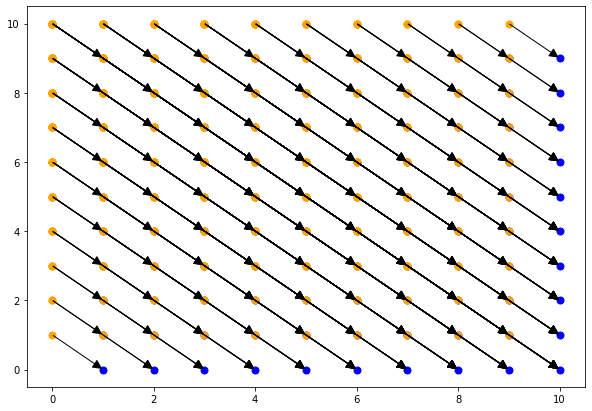

In [20]:
from islplot.plotter import *
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_map(dep_flow_T)

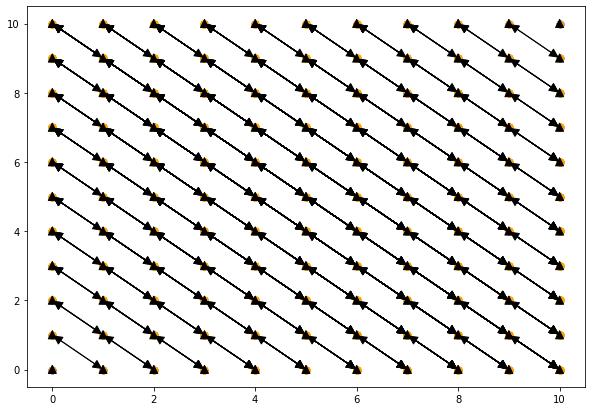

In [21]:
plt.figure(figsize=(10,7))
plot_map(potential)

 
<!-- The first thing we observe that self-dependences of statement instances are gone.
Indeed, a statement instance cannot be executed before itself. -->

实际上每个statement instance是不能在其自身之前被执行, 因此观察到statement instances的self-dependences消失了.

### Question
<!-- Plot the dependence *samples* for the instance $( \mathtt{T}(4,2) )$, i.e. the statements instances it depends upon and the statement instances that depend on it. -->
绘制instance $ \mathtt{T}(4,2) $ instance 的依赖 *samples*，即它所依赖的statement instances和依赖它的statement instances.

In [22]:
point = isl.Set("{T[i,j]: i = 4 and j = 2}") # 添加instance point约束
sources = dep_flow_T.intersect_range(point) 
sinks = dep_flow_T.intersect_domain(point)
print(sources)
print(sinks)

{ T[i, j = 6 - i] -> T[i' = 4, j' = 2] : 0 <= i <= 3 }
{ T[i = 4, j = 2] -> T[i', j' = 6 - i'] : 5 <= i' <= 6 }


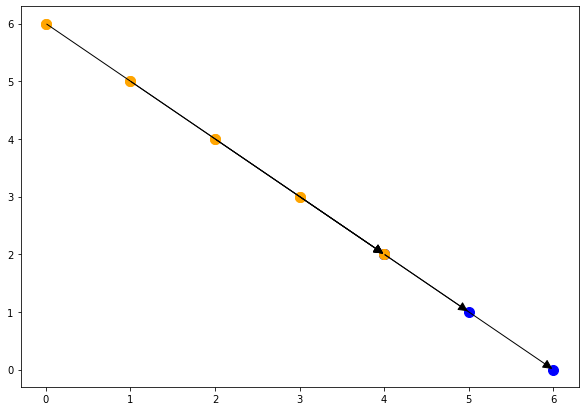

In [23]:
# sources : 4 + 2 = 6, 他依赖于 [0,6], [1,5], [2,4], [3,3] 这些instance.
# sinks: [5,1],[6,0]依赖于[4,2]
plt.figure(figsize=(10,7))
plot_map([sources, sinks], marker_size=10)  


<!-- Now you see that it depends on statement instances that access the same array element and are executed *before* it.
Similarly, only the statement instances executed *after* the given statement depend on it. -->
现在可以看到依赖于给定statement instances的实例都是访问相同数组元素并在它之前执行的实例,
类似地, 在给定statement instances之后执行的语句实例依赖于它.

### Anti and Output Dependences
<!-- Anti-dependences are the inverse of flow dependences, that is write-after-read.
Respecting them means that the value will not be overwritten before it is read.
Output dependences, or write-after-write, preserve the order of writes.
Both of them are sometimes called *false* dependences in a sense that the *sink* statement instance does not actually *depend* on the *data* produced by the *source* statement instance.
It rather needs to be executed later to avoid interference with other statement instances. -->

Anti-dependences是flow dependencs的reverse,即先读后写,
考虑Anti-dependences意味着在读取之前不覆盖他的值,
Output dependences,或写后再写,需要保留写的顺序.

这些通常都被称为 *false* dependences,因为 *sink* 实例实际上并不 **依赖** *source* 语句实例产生的 *data*,
而是需要在后面执行以避免干扰其他实例.

<!-- The *sink* of the false dependences is always as a write access while the source can be either a read or write.
Therefore, we compose the union of reads and writes on the left with inverted writes on the right -->
false dependences的 *sink* 通常是写访问,而*source*可以是读或写,
因此我们将左侧的读写union与右侧的reverse写组合:

$( (\mathtt{reads} \cup \mathtt{writes}) \circ \mathtt{writes}^{-1} )$.
<!-- We then proceed as before. -->

In [24]:
dep_false = writes.union(reads).apply_range(writes.reverse())
dep_false = dep_false.apply_domain(schedule).apply_range(schedule)
dep_false = dep_false.intersect(precedes)
dep_false = dep_false.apply_domain(schedule.reverse()).apply_range(schedule.reverse())
print(dep_false)

{ T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and i' > i and 0 <= i' <= 10 and i' <= i + j; S[i] -> T[i', j = i - i'] : i' >= -10 + i and 0 <= i' <= 10 and i' <= i }


<!-- In our example, false dependences correspond exactly to flow dependences because `S` only writes and `T` reads and writes the same element.
It is not generally the case. -->

在这个例子中,false dependences与flow dependences完全对应,因为`S`只写入,而`T`只读取和写入相同的元素.
实际上一般情况并非如此.

In [25]:
print(dep_false.is_equal(dep_flow))

True


### Question: Input Dependences
<!-- 
Even though they are usually not enforced, *input*, or read-after-read, dependences can be useful in program optimization.
Compute the input dependences similarly to the two previous cases. -->

即使*input* 或连续读取通常不被强制执行, 但这个得到他们的依赖关系在程序优化中也很有用.
因此与前两种情况类似地计算input dependences:

In [26]:
dep_input = reads.apply_range(reads.reverse()) # 获得reads after reads的map
dep_input = dep_input.apply_domain(schedule).apply_range(schedule) # 添加约束.
dep_input = dep_input.intersect(precedes) # 和词典序做交集.
dep_input = dep_input.apply_domain(schedule.reverse()).apply_range(schedule.reverse()) # 再将其反向映射到数据点上, 
print(dep_input)

{ T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and i' > i and 0 <= i' <= 10 and i' <= i + j; T[i, j] -> T[i' = i, j'] : 0 <= i <= 10 and 0 <= j <= 10 and j' > j and 0 <= j' <= 10; T[i, j] -> T[i', j' = j] : 0 <= i <= 10 and 0 <= j <= 10 and i' > i and 0 <= i' <= 10 }


<!-- Input dependence seems to differ from flow and false once. -->
<!-- In particular, only instances of `T` are involved in this dependence.
This is due to the fact that `S` never reads a value. -->
Input dependence看起来和flow dependence/false dependence不同,
其中只出现了`T`的实例, 这是因为`S`从来没有读过任何值.

### Question
<!-- Plot dependence *samples* of the input dependence. -->
绘制input dependence的*samples*:


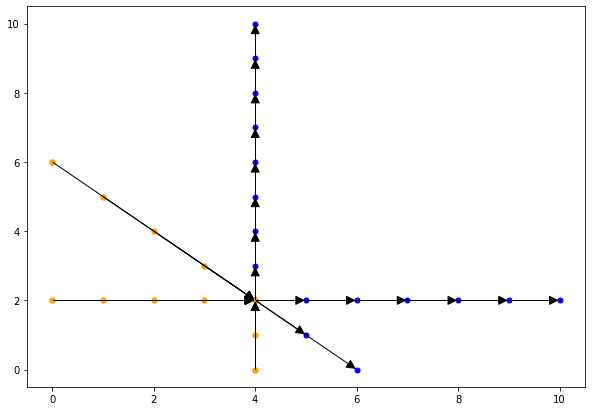

In [27]:
point = isl.Set("{T[i,j]: i = 4 and j = 2}")
# sources 其中竖线表示B[0,1,2]时多次读取A[4]的依赖, 横线表示B[2]时多次读取A[0,1,2,3]的依赖, 斜线表示Z[4,2]对Z[(0+6),(1+5),(2+4),(3+3)]的依赖
sources = dep_input.intersect_range(point) 
sinks = dep_input.intersect_domain(point)
plt.figure(figsize=(10,7))
plot_map([sources, sinks], marker_size=5)

<!-- The complex pattern of dependences is caused by reading from multiple different arrays in the same statement intances -->

复杂的依赖pattern会导致同一个statement instance从多个不同的array读取数据.

## Value-based Analysis
<!-- You may observe that each statement instance depends on *all* instances that access the same array element.
Yet is it not always necessary. -->
<!-- Consider the flow dependence pattern for `T(4,2)` and `T(5,1)`. -->

可以观察到每个statement instance依赖了*所有*访问相同数组元素的实例,但是其实并不是必要的.
比如`T(4,2)`和`T(5,1)`的flow dependence:


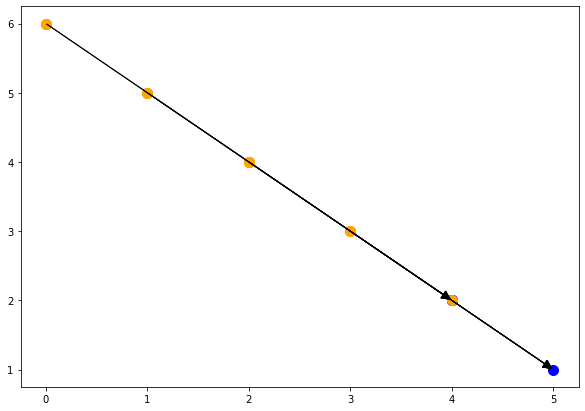

In [28]:
point1 = isl.Set("{T[i,j]: i = 4 and j = 2}")
point2 = isl.Set("{T[i,j]: i = 5 and j = 1}")
sources1 = dep_flow_T.intersect_range(point1)
sources2 = dep_flow_T.intersect_range(point2)
plt.figure(figsize=(10,7))
plot_map([sources1, sources2],marker_size=10)


<!-- `T(5,1)` depends on all the same instances as `T(4,2)` and on `T(4,2)` itself. -->
其中`T(5,1)` 依赖`T(4,2)`所依赖的所有实例以及`T(4,2)`本身.



In [29]:
print(sources2.domain().subtract(point1).is_equal(sources1.domain())) # 检查是否是子集.

True



<!-- If `T(4,2)` needs to be scheduled after `T(3,3)` and `T(5,1)` needs to be scheduled after `T(4,2)`, then
`T(5,1)` also needs to be scheduled after `T(3,3)`.  So the dependence between these two instances is *transitively covered* by
dependences between other instances. -->
如果将`T(4,2)`调度到`T(3,3)`之后, 那么`T(5,1)`也需要被调度到`T(4,2)`之后, 然后`T(5,1)`也需要调度到`T(3,3)`之后. 所以这两个实例之间的依赖关系*transitively covered(传递地覆盖)*其他实例之间的依赖.

<!-- We can remove the transitively covered flow dependences safely.
This can be done by computing lexicographically largest source instance for any sink instance in a dependence, and by removing all the other sources. -->

我们可以安全地移除传递覆盖的flow dependence.
通过计算词典序最大的source instance对于任意sink instance的依赖,然后删除其他的source instance来完成.

<!-- Such computation is non-trivial and may involve solution of a linear optimization problem.  *isl* provides functionality to perform this *value-based* analysis directly.
However, it uses a more elaborate *tree* structure for the schedules.
For the sake of this example, we will provide this schedule without further explanation. -->

但以上的计算是non- trivial的,并且可能涉及到线性优化问题的求解, *isl*提供了*value-based*分析的功能.
但是,它会使用更加精确的树结构来调度, 对于这个例子, 我们将直接提供这个schedule:

In [30]:
schedule = isl.Schedule('{ domain: "{ T[i, j] : 0 <= i <= 10 and 0 <= j <= 10; S[i] : 0 <= i <= 20 }", child: { sequence: [{ filter: "{ S[i] }", child: { schedule: "[{S[i] -> [(i)]}, {S[i] -> [(0)]}]" }}, { filter: "{ T[i, j] }", child: { schedule: "[{T[i, j] -> [(i)]}, {T[i, j] -> [(j)]}]" }} ] } }')

<!-- ###  -->
<!-- Now it is possible to set up the *value-based* dependence analysis -->
现在可以来进行*value-based*的依赖分析:

In [31]:
uai = isl.UnionAccessInfo.from_sink(reads)
uai = uai.set_must_source(writes)
uai = uai.set_schedule(schedule)
flow = uai.compute_flow()
dep_flow_precise = flow.get_may_dependence()
print(dep_flow_precise)

{ S[i] -> T[i' = -10 + i, j = 10] : 10 <= i <= 20; S[i] -> T[i' = 0, j = i] : 0 <= i <= 9; T[i, j] -> T[i' = 1 + i, j' = -1 + j] : 0 <= i <= 9 and 0 < j <= 10 }


<!-- ###  -->
<!-- This depenedence relation no longer includes the transitively covered cases. -->
现在依赖关系已经不再包含transitively covered的例子了.

### Question
<!-- Constrain the dependence to instances of `T` only and plot *samples* for instances `T(4,2)` and `T(5,1)`.
Compare them with those obtained for *memory-based* analysis. -->
将依赖关系限制在`T`上, 然后绘制`T(4,2)` 和 `T(5,1)`的samples, 并将他们*memory-based*的分析结果进行比较.

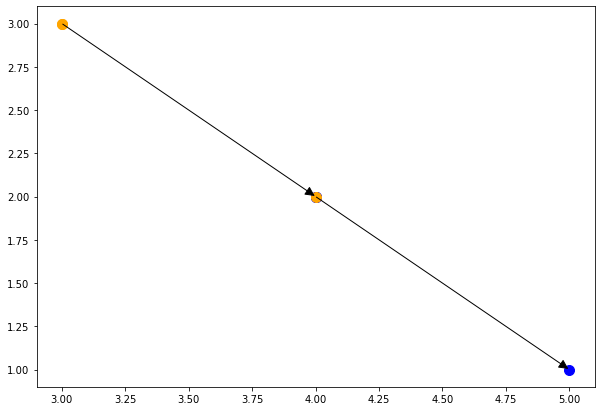

In [32]:
dep_flow_precise_T = dep_flow_precise.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))
sources1 = dep_flow_precise_T.intersect_range(point1)
sources2 = dep_flow_precise_T.intersect_range(point2)
plt.figure(figsize=(10,7))
plot_map([sources1, sources2], marker_size=10)

### 
<!-- As you may see, each `T` instance now depends exactly on only one other `T` instance. -->
可以发现,每个`T`的实例限制只依赖一个其他`T`的实例.

<!-- *Memory-based* dependences can be recovered from *value-based* dependences by computing the transitive closure of the dependence relation. -->
*Memory-based* dependences可以通过计算依赖关系的transitive closure来从*value-based* dependences恢复出来:


### Question
<!-- Compute input dependences using *value-based* procedure.  Visualize their patterns. -->
使用*value-based*的过程计算input dependences, 并且可视化:

In [33]:
uai = isl.UnionAccessInfo.from_sink(reads)
uai = uai.set_must_source(reads)
uai = uai.set_schedule(schedule)
flow = uai.compute_flow()
dep_input_precise = flow.get_may_dependence()
print(dep_input_precise)

{ T[i, j] -> T[i' = i, j' = 1 + j] : 0 <= i <= 10 and 0 <= j <= 9; T[i, j] -> T[i' = 1 + i, j' = j] : 0 <= i <= 9 and 0 <= j <= 10; T[i, j] -> T[i' = 1 + i, j' = -1 + j] : 0 <= i <= 9 and 0 < j <= 10 }


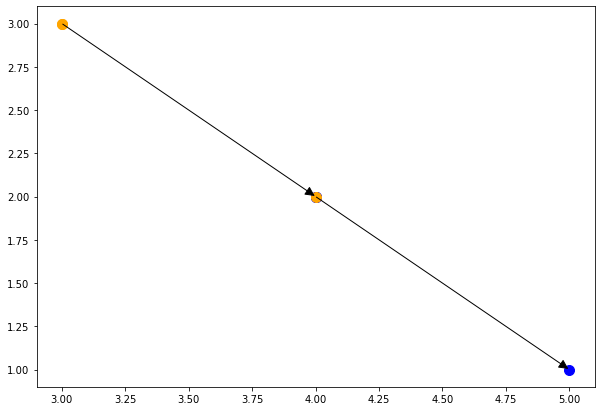

In [35]:
dep_flow_precise_T = dep_flow_precise.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))
sources1 = dep_flow_precise_T.intersect_range(point1)
sources2 = dep_flow_precise_T.intersect_range(point2)
plt.figure(figsize=(10,7))
plot_map([sources1, sources2], marker_size=10)